In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import lax, random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
def demand_sales_dgp(
    rng_key: ArrayImpl, n: int
) -> tuple[ArrayImpl, ArrayImpl, ArrayImpl, ArrayImpl, ArrayImpl]:
    t = jnp.arange(start=0, stop=n, step=1)
    demand = 2 * jnp.ones_like(t, dtype=jnp.float32)
    sales = jnp.zeros_like(t, dtype=jnp.float32)
    sales_obs = jnp.zeros_like(t, dtype=jnp.float32)

    rng_key, rng_subkey = random.split(rng_key)
    noise_demand = 0.3 * random.normal(rng_subkey, shape=(t.size,))

    rng_key, rng_subkey = random.split(rng_key)
    noise_sales = 0.5 * random.normal(rng_subkey, shape=(t.size,))

    rng_key, rng_subkey = random.split(rng_key)
    is_available = random.bernoulli(rng_subkey, 0.9, shape=(t.size,)).astype(
        jnp.float32
    )

    for i in range(2, t.size):
        demand_i = (
            0.6 * demand[i - 1]
            + 0.3 * demand[i - 1]
            + 0.5 * jnp.sin(2 * jnp.pi * t[i] / 7)
            + 0.2
            + noise_demand[i]
        )
        demand_i = jnp.maximum(demand_i, 0)
        demand = demand.at[i].set(demand_i)  # noqa

        sales_i = demand[i] + noise_sales[i] - 0.2
        sales_i = jnp.minimum(sales_i, demand_i)
        sales_i = jnp.maximum(sales_i, 0)
        sales_i_obs = is_available[i] * sales_i
        sales_i_obs = jnp.minimum(sales_i_obs, 2.3)
        sales = sales.at[i].set(sales_i)  # noqa
        sales_obs = sales_obs.at[i].set(sales_i_obs)  # noqa

    return t, demand, sales, sales_obs, is_available


n = 180
rng_key, rng_subkey = random.split(rng_key)
t, demand, sales, sales_obs, is_available = demand_sales_dgp(rng_subkey, n)

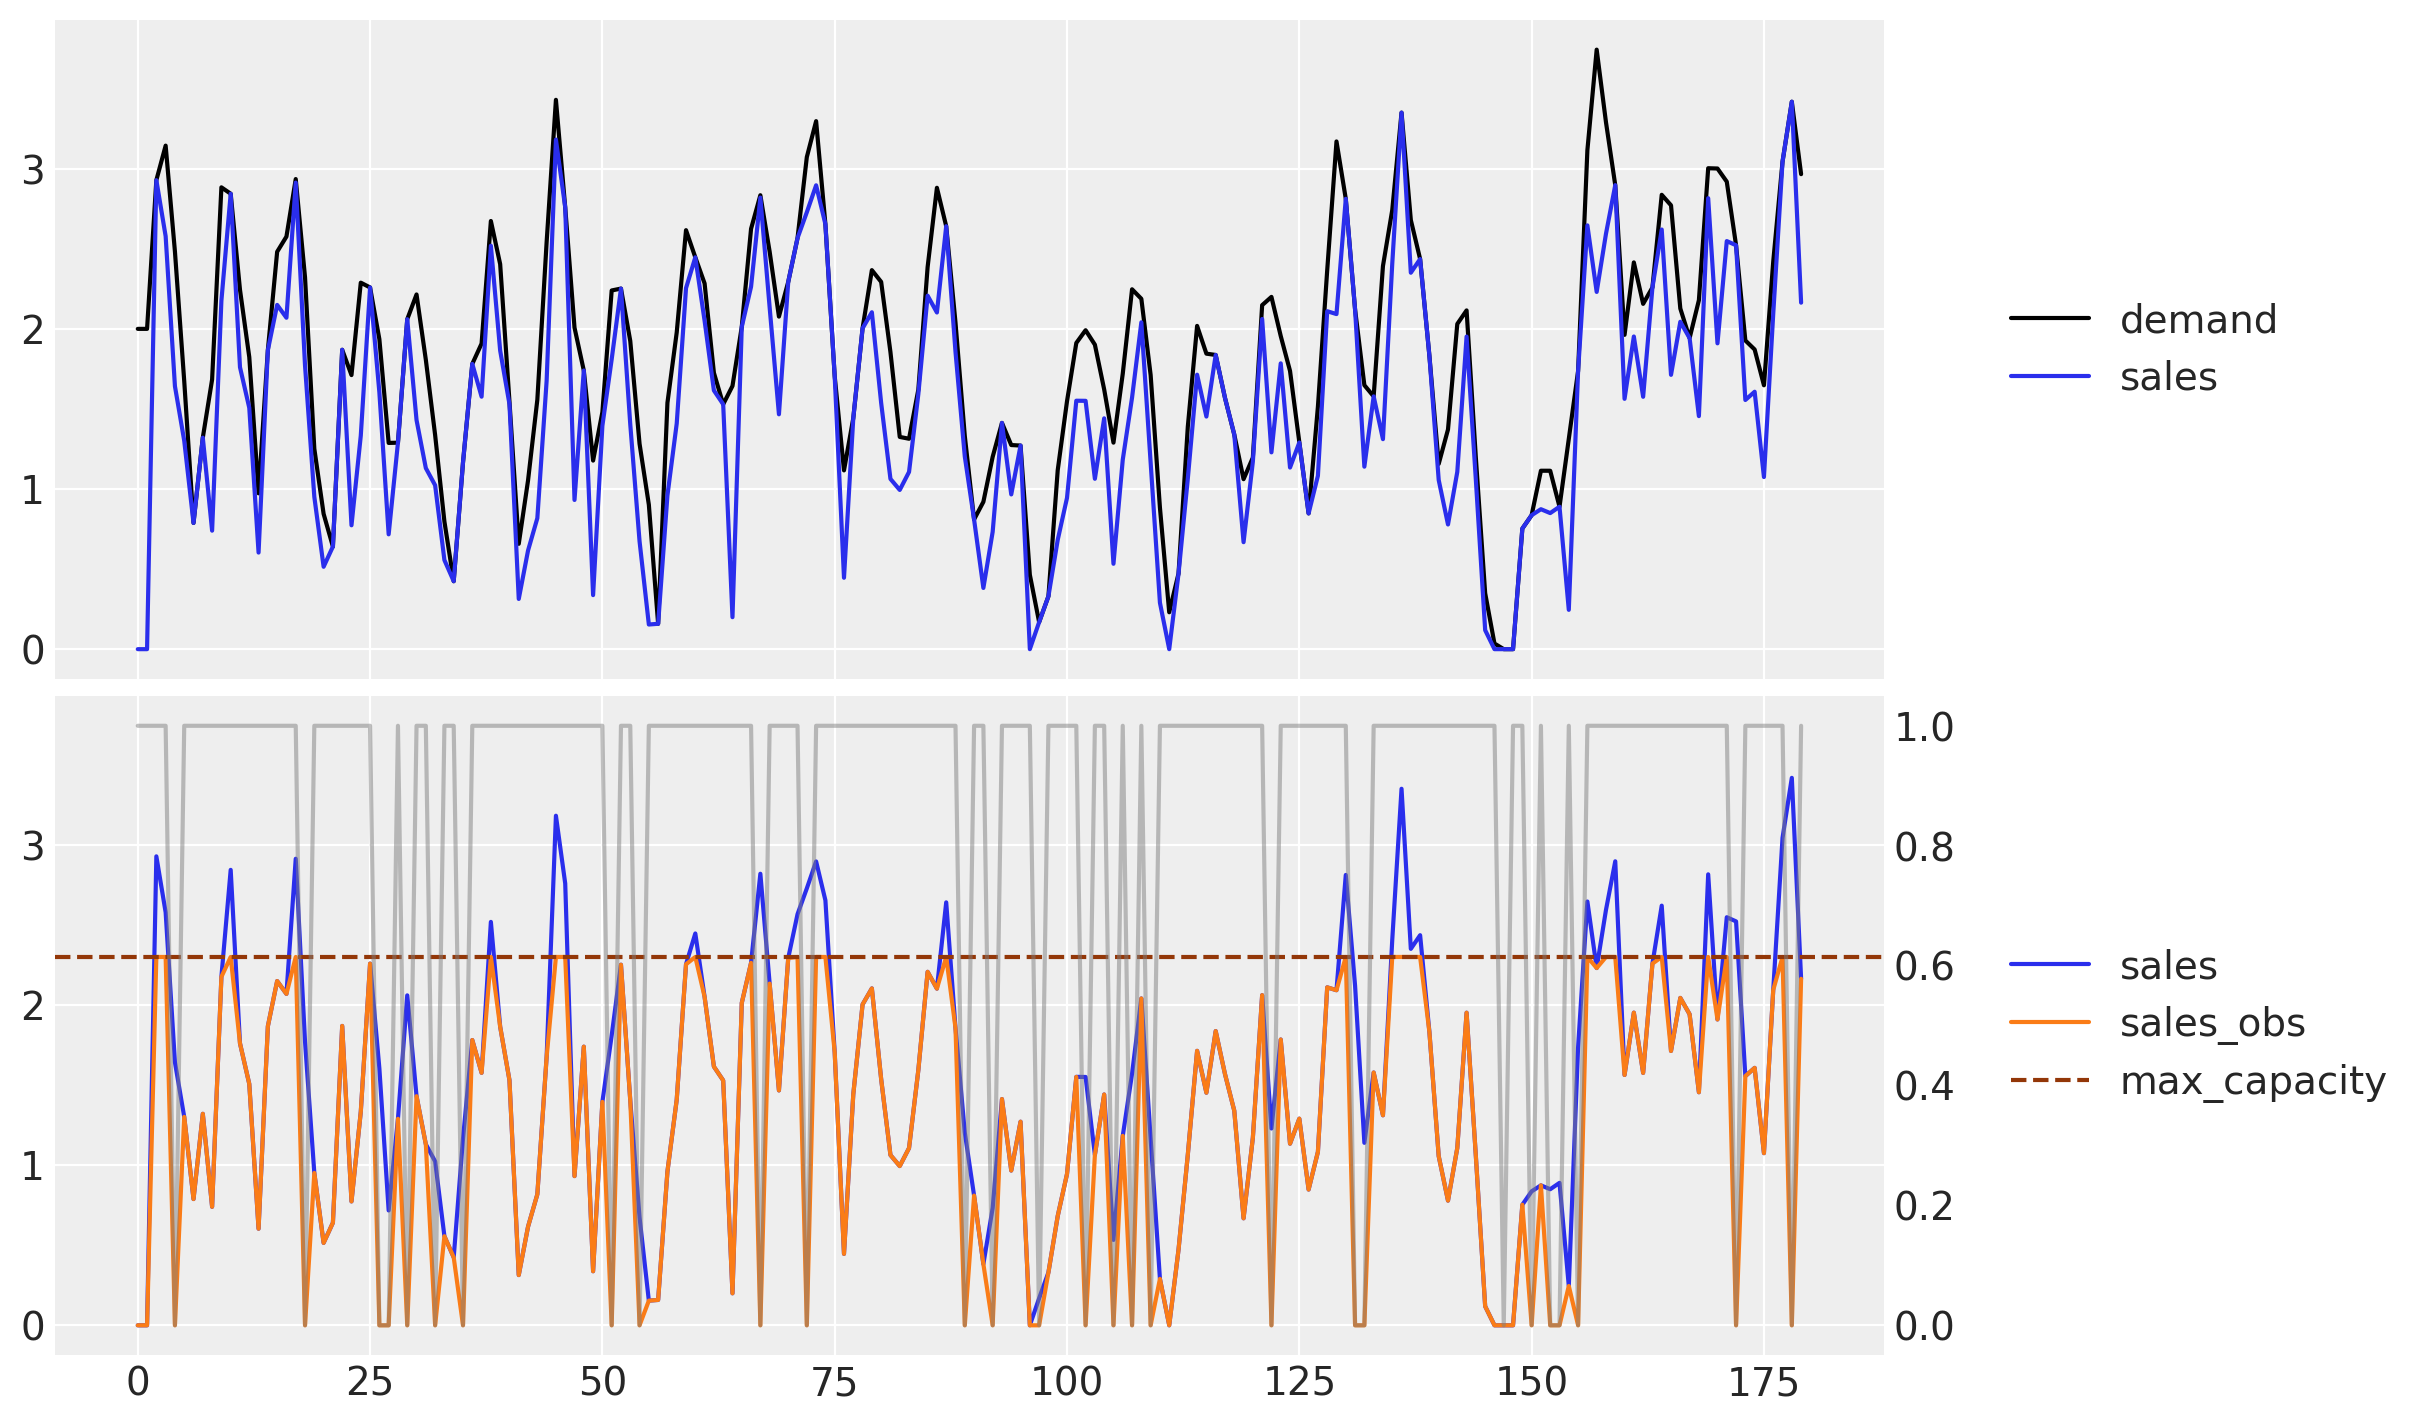

In [3]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 7),
    sharex=True,
    sharey=True,
    layout="constrained",
)

ax[0].plot(t, demand, c="black", label="demand")
ax[0].plot(t, sales, c="C0", label="sales")
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

ax[1].plot(t, sales, c="C0", label="sales")
ax[1].plot(t, sales_obs, c="C1", label="sales_obs")
ax1_twin = ax[1].twinx()
ax1_twin.plot(t, is_available, c="gray", alpha=0.5, label="is_available")
ax[1].axhline(2.3, color="C4", linestyle="--", label="max_capacity")
ax1_twin.grid(False)
ax[1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5));

In [4]:
forecast_horizon = 15

t_train = t[:-forecast_horizon]
demand_train = demand[:-forecast_horizon]
sales_train = sales[:-forecast_horizon]
sales_obs_train = sales_obs[:-forecast_horizon]
is_available_train = is_available[:-forecast_horizon]

t_test = t[-forecast_horizon:]
demand_test = demand[-forecast_horizon:]
sales_test = sales[-forecast_horizon:]
sales_obs_test = sales_obs[-forecast_horizon:]
is_available_test = is_available[-forecast_horizon:]
is_available_test_expected = jnp.ones_like(is_available_test)

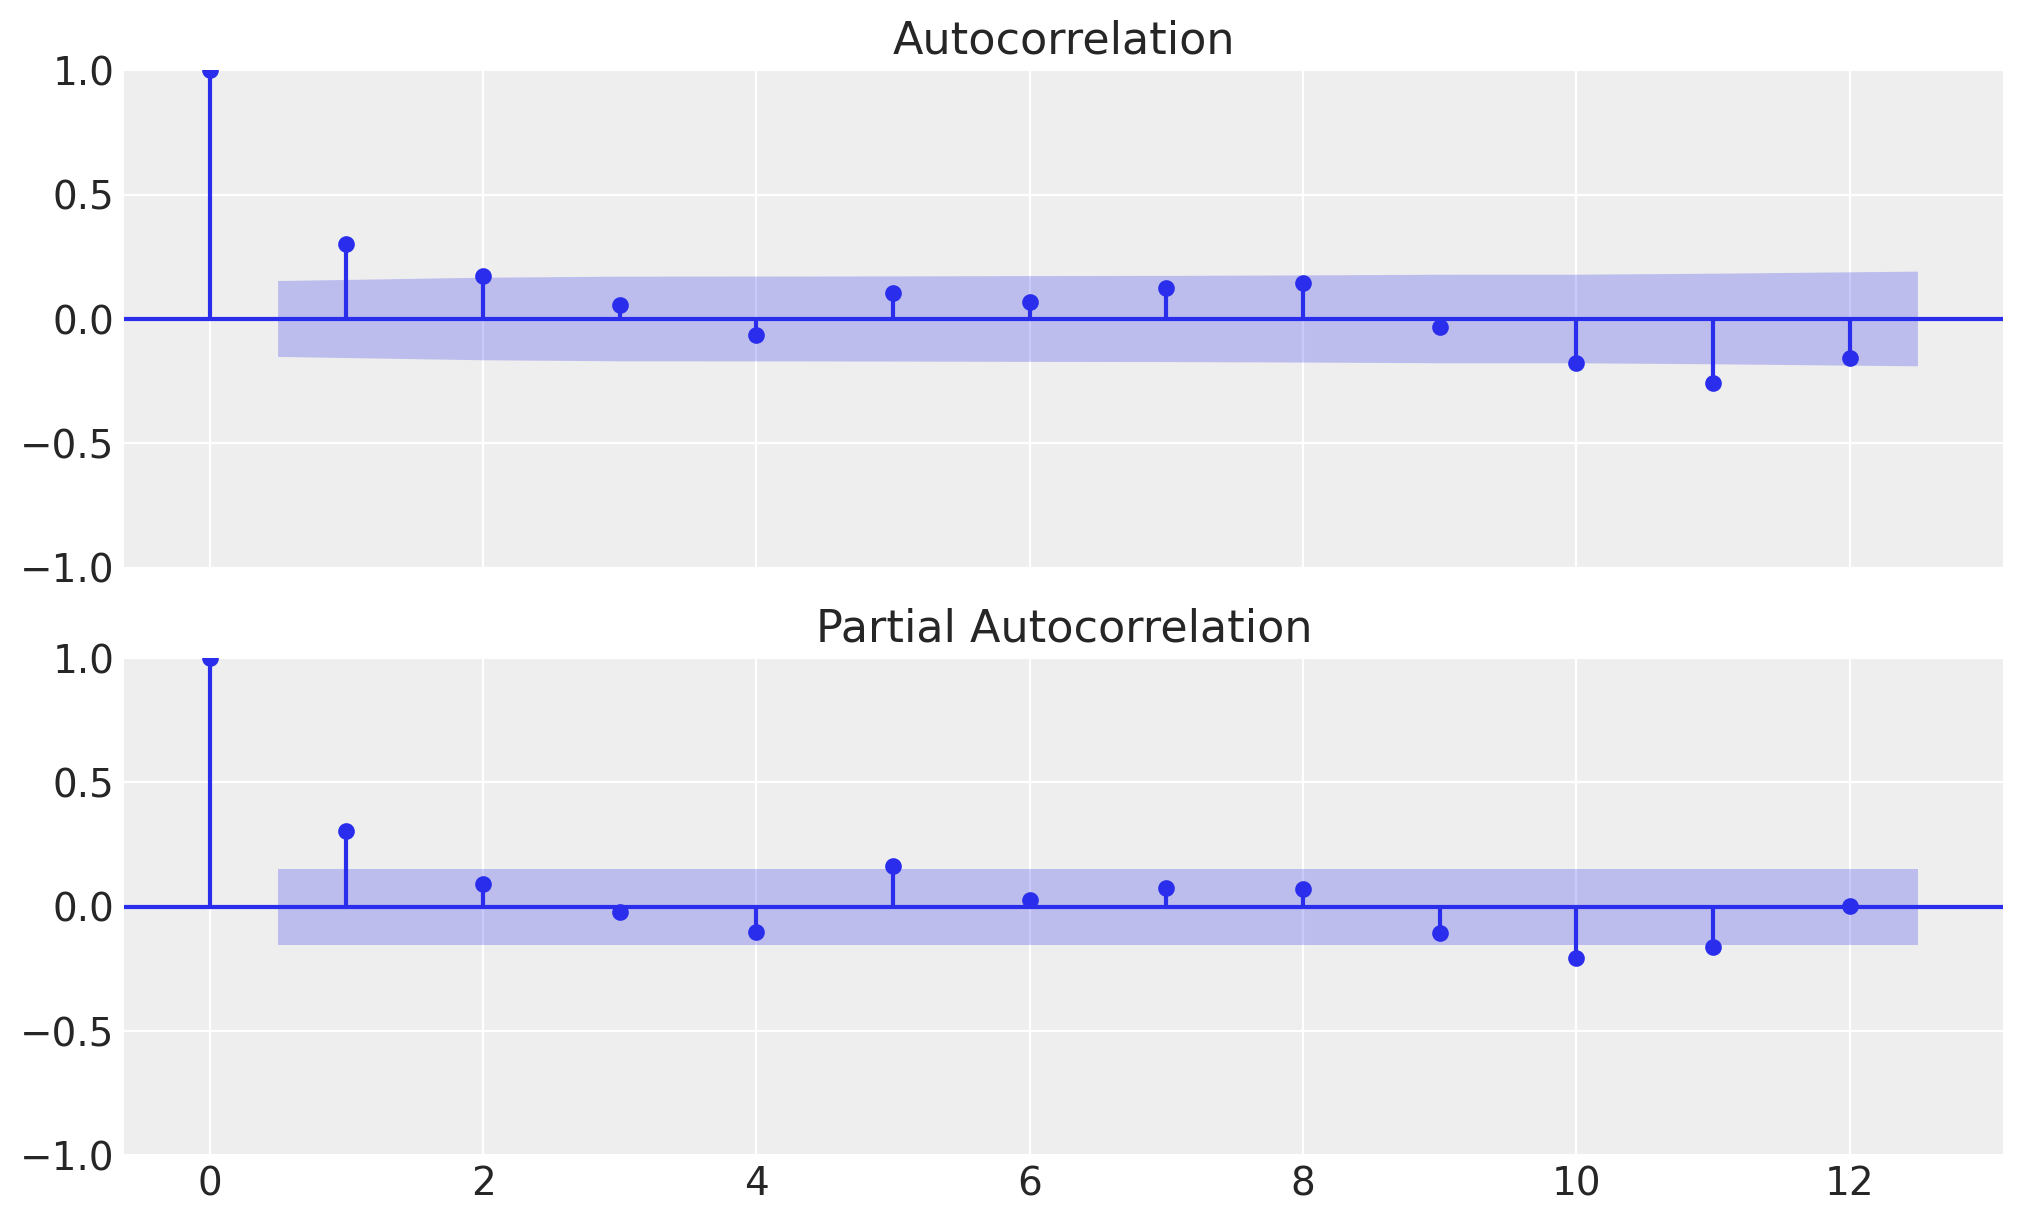

In [5]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 6), layout="constrained"
)

_ = plot_acf(sales_obs_train, lags=12, ax=ax[0])
_ = plot_pacf(sales_obs_train, lags=12, ax=ax[1])

In [48]:
model = ARIMA(
    endog=np.asarray(sales_obs_train),
    exog=is_available_train,
    order=(2, 0, 0),
    seasonal_order=(1, 0, 0, 7),
)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                               y   No. Observations:                  165
Model:             ARIMA(2, 0, 0)x(1, 0, 0, 7)   Log Likelihood                -142.923
Date:                         Sun, 07 Apr 2024   AIC                            297.847
Time:                                 10:34:10   BIC                            316.483
Sample:                                      0   HQIC                           305.412
                                         - 165                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0806      0.176      0.458      0.647      -0.264       0.425
x1             1.3222      0.141      9.374      0.000       1.046       1.599
ar.L1          0.4204      0.078      5.404      0.000       0.268       0.573
ar.L2         -0.0155      0.071     -0.220      0.826      -0.154       0.123
ar.S.L7        0.2055      0.084      2.453      0.014       0.041       0.370
sigma2         0.3301      0.045      7.267      0.000       0.241       0.419
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 4.81
Prob(Q):                              0.89   Prob(JB):                         0.09
Heteroskedasticity (H):               0.90   Skew:                            -0.35
Prob(H) (two-sided):                  0.71   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

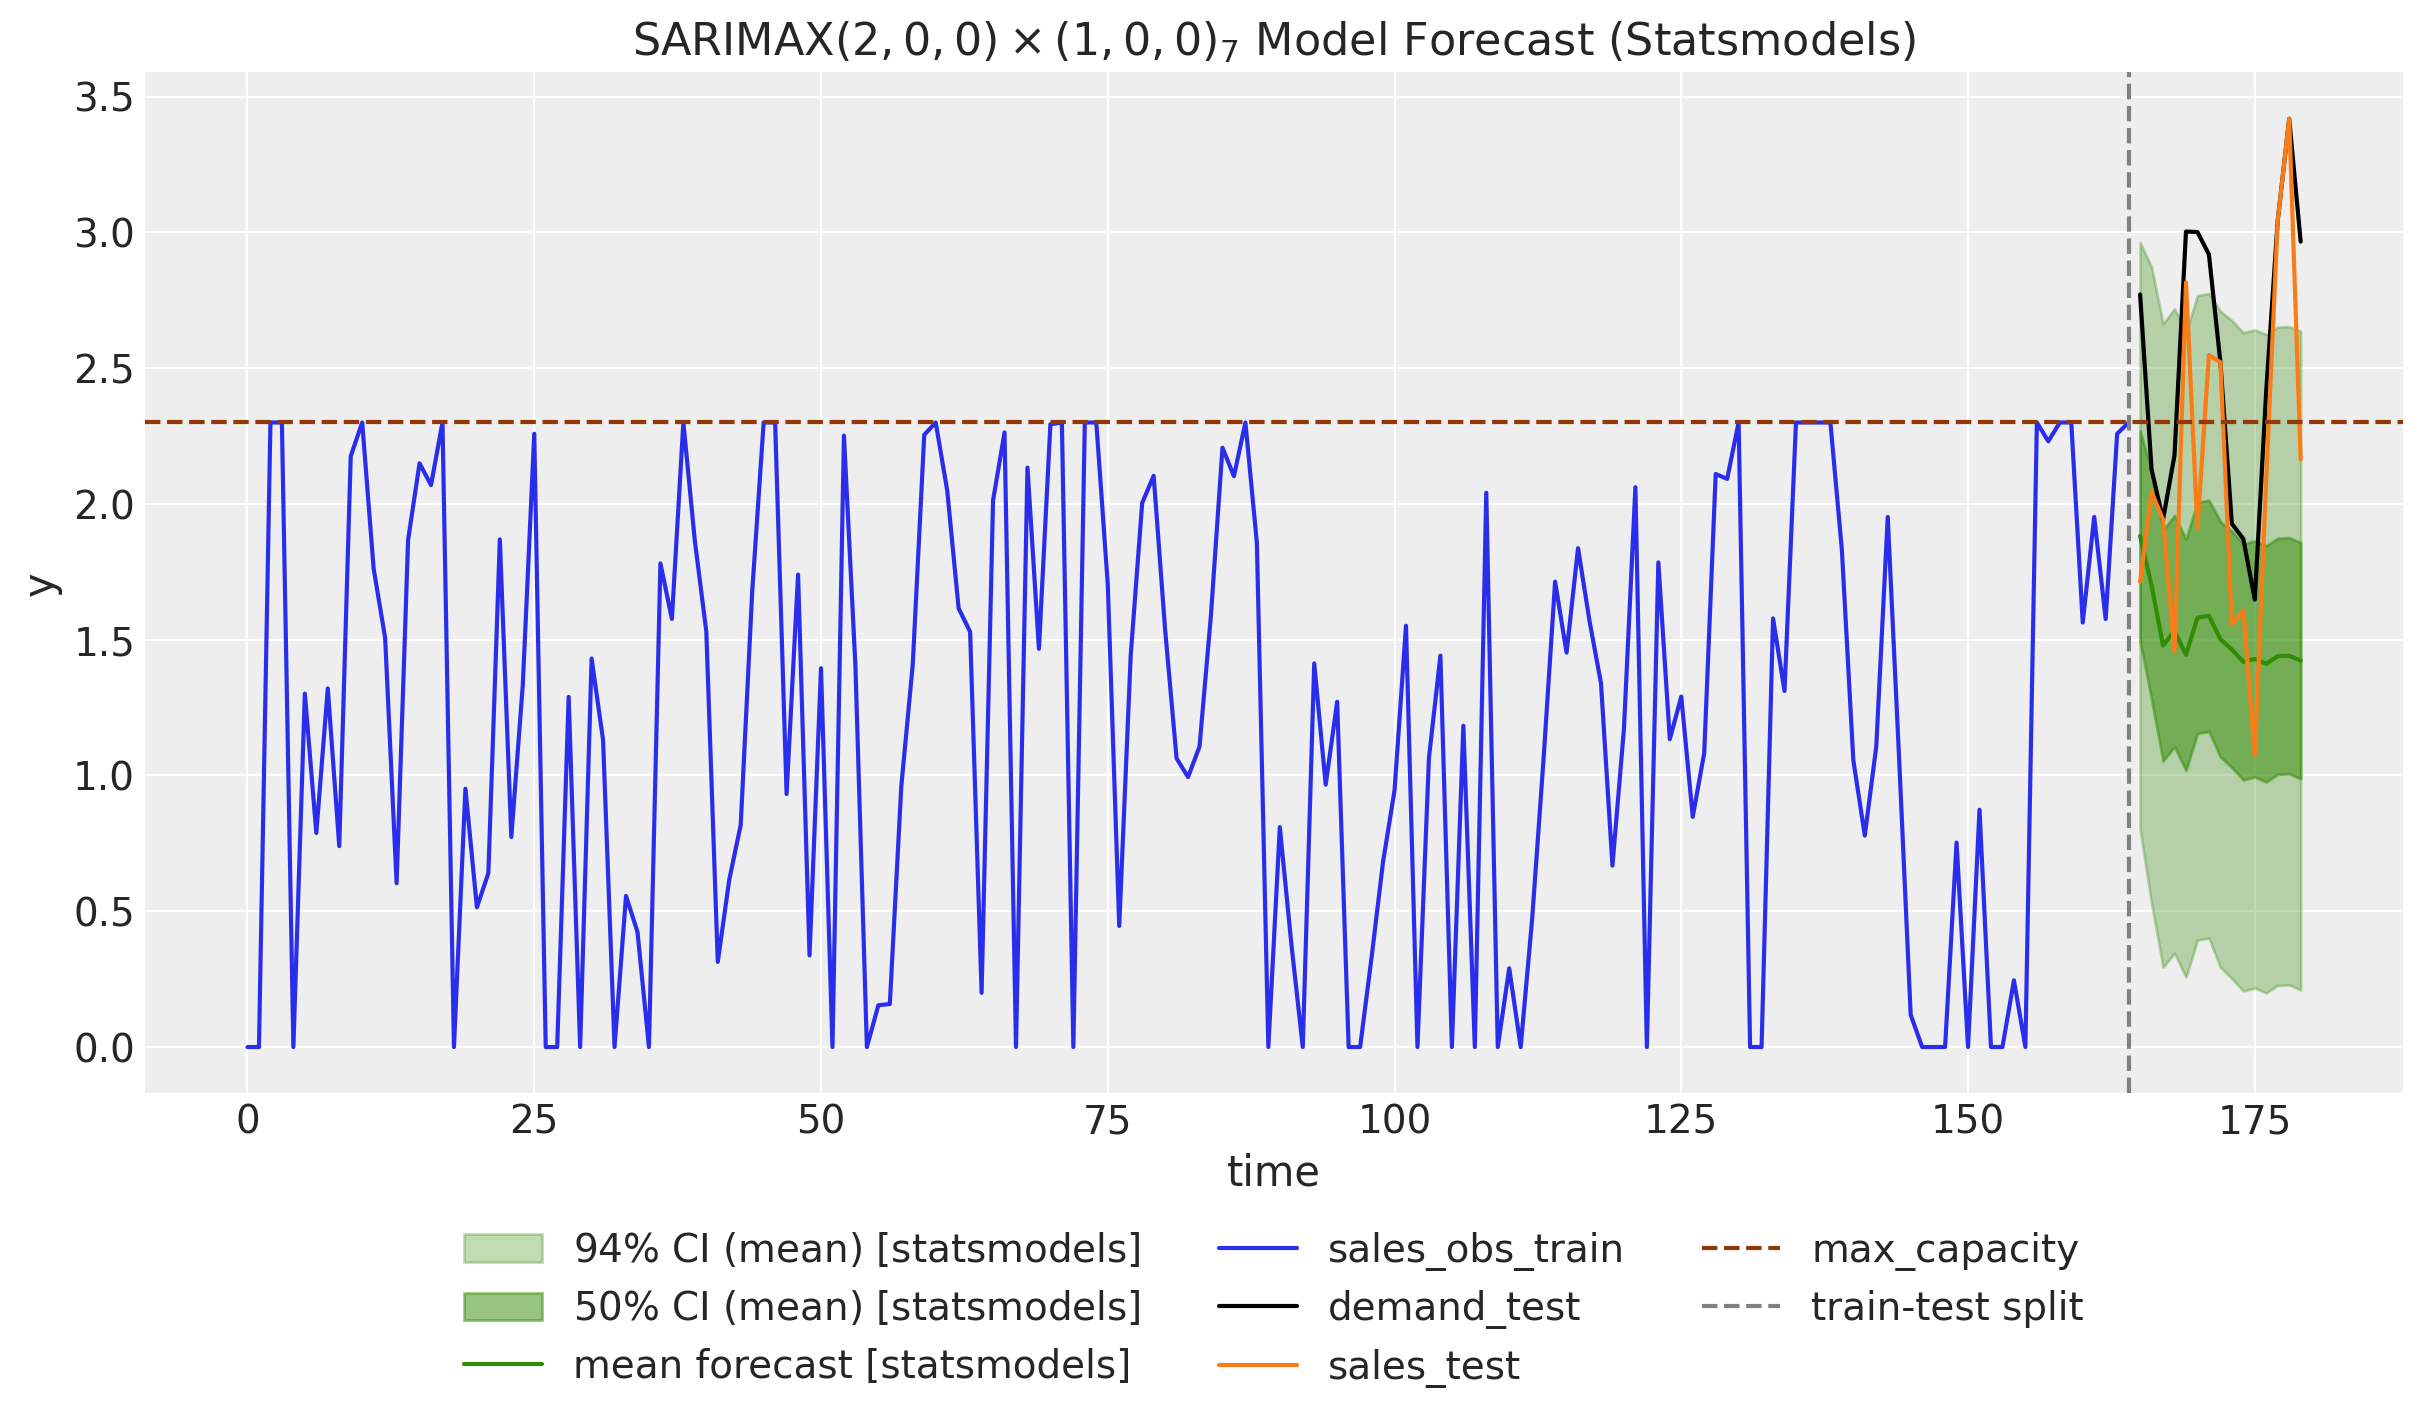

In [52]:
forecast_94_df = result.get_forecast(
    steps=sales_obs_test.size, exog=is_available_test_expected
).summary_frame(alpha=0.06)

forecast_50_df = result.get_forecast(
    steps=sales_obs_test.size, exog=is_available_test_expected
).summary_frame(alpha=0.5)

fig, ax = plt.subplots()
ax.fill_between(
    t_test,
    forecast_94_df["mean_ci_lower"],
    forecast_94_df["mean_ci_upper"],
    color="C2",
    alpha=0.3,
    label=r"$94\%$ CI (mean) [statsmodels]",
)
ax.fill_between(
    t_test,
    forecast_50_df["mean_ci_lower"],
    forecast_50_df["mean_ci_upper"],
    color="C2",
    alpha=0.5,
    label=r"$50\%$ CI (mean) [statsmodels]",
)
ax.plot(t_test, forecast_94_df["mean"], color="C2", label="mean forecast [statsmodels]")
ax.plot(t_train, sales_obs_train, color="C0", label="sales_obs_train")
ax.plot(t_test, demand_test, color="black", label="demand_test")
ax.plot(t_test, sales_test, color="C1", label="sales_test")
ax.axhline(y=2.3, c="C4", linestyle="--", label="max_capacity")
ax.axvline(x=t_train[-1], c="gray", linestyle="--", label="train-test split")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(
    xlabel="time",
    ylabel="y",
    title="SARIMAX$(2, 0, 0)\\times(1, 0, 0)_{7}$ Model Forecast (Statsmodels)",
);